## Setup & Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style('whitegrid')
print("Libraries imported.")

# Loading the CLEAN data, featured data not needed as these models don't use the extra features
try:
    master_df = pd.read_csv('../data/cleaned_master_data.csv', parse_dates=['Date'])
    print("Clean master data loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'cleaned_master_data.csv' not found. Please run notebook 01 first.")

# Creating an aggregated time series of total weekly sales
total_sales = master_df.groupby('Date')['Weekly_Sales'].sum()

# Spliting data into training (before 2012) and testing (2012 onwards)
train_series = total_sales[total_sales.index < '2012-01-01']
test_series = total_sales[total_sales.index >= '2012-01-01']
print(f"Data split into {len(train_series)} training weeks and {len(test_series)} test weeks.")


Importing plotly failed. Interactive plots will not work.


Libraries imported.
Clean master data loaded successfully.
Data split into 100 training weeks and 43 test weeks.


## Baseline Models

In [ ]:
# --- Baseline Models ---
print("\n--- Evaluating Baseline Models ---")


test_df = test_series.reset_index()
test_df.columns = ['Date', 'Weekly_Sales']

# Creating Naive forecast (last week's sales) and prepare it for merging
naive_df = total_sales.shift(1).reset_index()
naive_df.columns = ['Date', 'Naive_Forecast']

# Creating Seasonal Naive forecast (last year's sales) and prepare it for merging
seasonal_naive_df = total_sales.shift(52).reset_index()
seasonal_naive_df.columns = ['Date', 'Seasonal_Naive_Forecast']

# Merging forecasts onto the test dataframe based on the 'Date'
test_df = pd.merge(test_df, naive_df, on='Date', how='left')
test_df = pd.merge(test_df, seasonal_naive_df, on='Date', how='left')

# Droping any rows where a forecast could not be generated (at the very beginning of the series)
test_df.dropna(inplace=True)

# Calculating the metrics on the clean, correctly merged data
mae_naive = mean_absolute_error(test_df['Weekly_Sales'], test_df['Naive_Forecast'])
print(f"Naive Forecast MAE: ${mae_naive:,.2f}")

mae_seasonal_naive = mean_absolute_error(test_df['Weekly_Sales'], test_df['Seasonal_Naive_Forecast'])
print(f"Seasonal Naive Forecast MAE: ${mae_seasonal_naive:,.2f}")


--- 2. Evaluating Baseline Models ---
Naive Forecast MAE: $1,898,194.10
Seasonal Naive Forecast MAE: $1,483,137.47


## SARIMA Model

--- Data Preparation Complete ---
--- Starting SARIMA Model Training... ---


c:\Users\SGB\anaconda3\envs\walmart_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SGB\anaconda3\envs\walmart_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SGB\anaconda3\envs\walmart_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SGB\anaconda3\envs\walmart_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SGB\anaconda3\envs\walmart_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

--- Model Training Complete ---
--- Generating Forecasts and Evaluating... ---


c:\Users\SGB\anaconda3\envs\walmart_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\SGB\anaconda3\envs\walmart_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


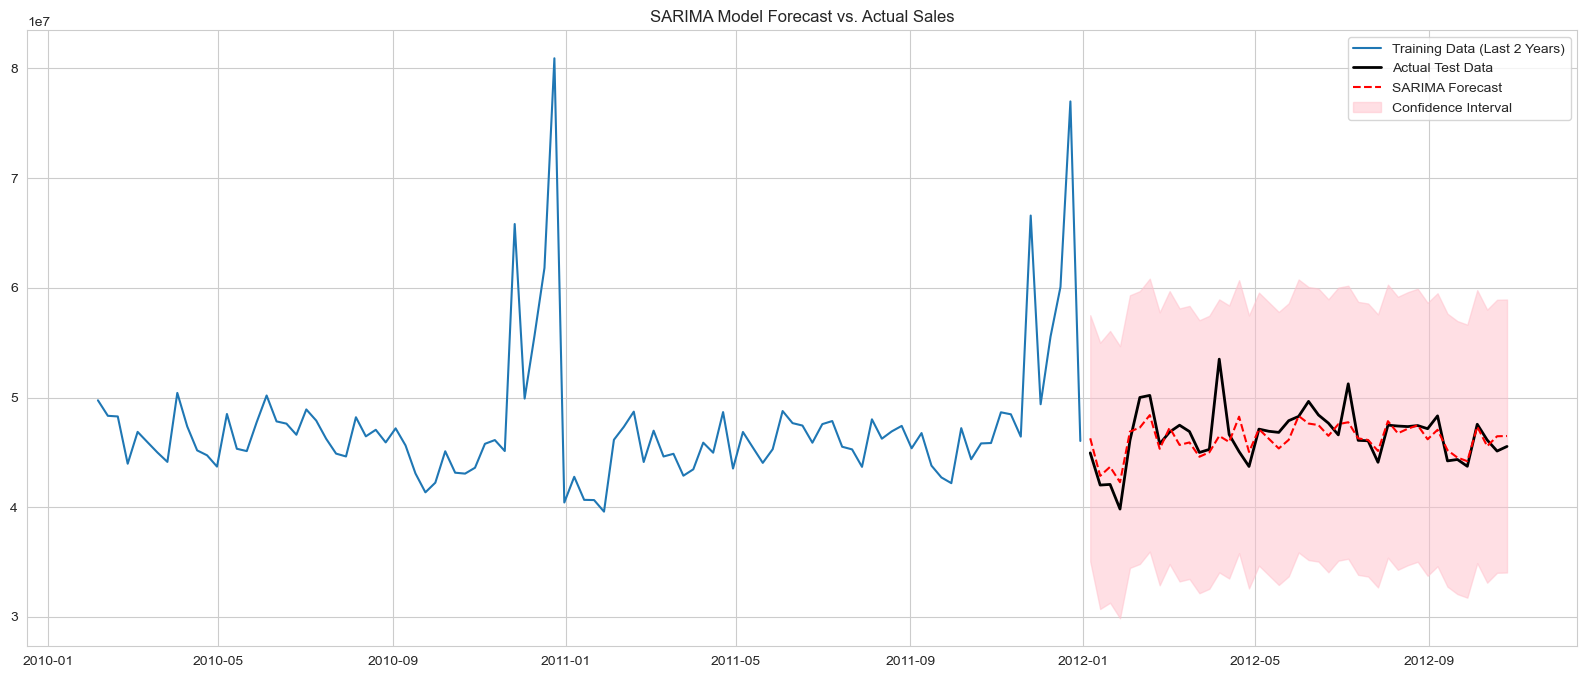


--- SARIMA Model Evaluation Metrics ---
Mean Absolute Error (MAE): $1,163,322.90
Root Mean Squared Error (RMSE): $1,686,446.59


In [ ]:
# SETUP & DATA PREPARATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style('whitegrid')

# Loading the clean data
master_df = pd.read_csv('../data/cleaned_master_data.csv', parse_dates=['Date'])

# Creating an aggregated time series of total weekly sales
total_sales = master_df.groupby('Date')['Weekly_Sales'].sum()

# Spliting data into training and testing sets
train_series = total_sales[total_sales.index < '2012-01-01']
test_series = total_sales[total_sales.index >= '2012-01-01']
print("--- Data Preparation Complete ---")


# MODEL TRAINING
print("--- Starting SARIMA Model Training... ---")
# Using auto_arima to find the best model
sarima_model = pm.auto_arima(train_series,
                             seasonal=True, m=52,
                             stepwise=True, suppress_warnings=True, trace=False)
print("--- Model Training Complete ---")


# FORECASTING & EVALUATION
print("--- Generating Forecasts and Evaluating... ---")
# Generate forecasts
n_periods = len(test_series)
forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)
forecast_series = pd.Series(forecast, index=test_series.index)

# Visual Evaluation
plt.figure(figsize=(20, 8))
plt.plot(train_series.tail(104), label='Training Data (Last 2 Years)')
plt.plot(test_series, label='Actual Test Data', color='black', linewidth=2)
plt.plot(forecast_series, label='SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(forecast_series.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.5, label='Confidence Interval')
plt.title('SARIMA Model Forecast vs. Actual Sales')
plt.legend()
plt.show()

# Quantitative Evaluation
mae = mean_absolute_error(test_series, forecast_series)
rmse = np.sqrt(mean_squared_error(test_series, forecast_series))

print(f"\n--- SARIMA Model Evaluation Metrics ---")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")